In [1]:
from collections import defaultdict, OrderedDict
from operator import itemgetter
from warnings import filterwarnings

import pandas as pd
import torch
from matplotlib import pyplot as plt
from more_itertools import stagger

# noinspection PyUnresolvedReferences
from clipppy.patches import torch_numpy

from libplotting import from_multidict, get_priors
from libsimplesn import SimpleSN


torch.set_default_tensor_type(torch.cuda.FloatTensor)

filterwarnings('ignore', module='torch.nn.modules.lazy')
filterwarnings('ignore', message='Named tensors')

In [2]:
simplesn = SimpleSN(survey='pantheon-g10', datatype='photoz', N=100_000, suffix=0, version=0)
config = simplesn.config('simplesn.yaml', gen=True)
defs = config.kwargs['defs']
nre = config.lightning_nre


ZOOMS = simplesn.zoom_bounds


COSMOGROUP = 'Om0', 'Ode0'
groups = [COSMOGROUP, *(key for key in nre.param_names if key not in COSMOGROUP)]


def priors_and_ranges(ranges, config_ranges=nre.dataset_config.kwargs.get('ranges', {})):
    dataset: CPDataset = nre.dataset.dataset
    dataset.ranges = config_ranges | ranges
    priors = get_priors(nre.param_names, dataset)
    return priors, {
        key: tuple(map(float, (prior.support.lower_bound, prior.support.upper_bound)))
        for key, prior in priors.items()}

zooms = pd.concat(
    {i: pd.DataFrame(priors_and_ranges(ranges)[1], index=['lower', 'upper']) for i, ranges in enumerate(ZOOMS)},
    axis='columns', names=('level', 'param')
)
zooms

level       0                                                            \
param sigma_z  Om0 Ode0 alpha beta mean_M0 sigma_res mean_x1 log10_R_x1   
lower   0.001  0.0  0.0   0.0  0.0   -21.0     0.001    -3.0       -5.0   
upper   0.200  2.0  2.0   1.0  4.0   -18.0     1.000     3.0        2.0   

level         ...         6                                           \
param mean_c  ...       Om0      Ode0     alpha      beta    mean_M0   
lower   -0.3  ...  0.258236  0.569842  0.128920  3.000380 -19.515093   
upper    0.3  ...  0.360408  0.818456  0.149355  3.172306 -19.464903   

level                                                     
param sigma_res   mean_x1 log10_R_x1    mean_c log10_R_c  
lower  0.070210 -0.018976  -0.007094 -0.002187 -1.005634  
upper  0.131644  0.020143   0.004635  0.001151 -0.993219  

[2 rows x 77 columns]

### Generate

In [3]:
from pathlib import Path
from clipppy.commands.nre import CPDataset
from clipppy.utils.plotting.nre import MultiNREPlotter

#### priors

In [4]:
priors, ranges = priors_and_ranges({})
plotter = MultiNREPlotter(
    groups=groups,
    grid_sizes=defaultdict(lambda: 256, Om0=128, Ode0=128),
    priors=priors, ranges=ranges, labels=defs['labels']
)

prior_grids = plotter.grids
priors = {group: pl.prior for group, pl in plotter.plotters.items()}

#### posteriors

In [ ]:
NROUNDS = 5  # len(ZOOMS)

data = simplesn.data
obs = {key: data[key] for key in nre.obs_names}

logsdir = Path('lightning_logs') / simplesn.basedata_prefix
nsteps = defaultdict(lambda: 9999) | {4: 19999}

grids = {}
posts = {}
for zoom_level, zoom in enumerate(ZOOMS[:NROUNDS]):
    logdir = logsdir / f'all-{zoom_level}'
    
    priors, ranges = priors_and_ranges(zoom)
    plotter = MultiNREPlotter(
        groups=groups,
        grid_sizes=defaultdict(lambda: 256, Om0=128, Ode0=128),
        priors=priors, ranges=ranges, labels=defs['labels']
    )
    
    grids[zoom_level] = plotter.grids

    for vpath in logdir.glob('**/version_*'):
        vrelpath = str(vpath.relative_to(logdir))
        checkpointdir = vpath / 'checkpoints'

        print(zoom_level, vrelpath)
        posts[(zoom_level, vrelpath)] = plotter.post(obs, *torch.load(checkpointdir / f'epoch=0-step={nsteps[zoom_level]}.ckpt')['clipppy_nets'])

In [ ]:
simplesn.zoom_posts = grids, {
    key: {k: (v.rename(None), v.names) for k, v in val.items()}
    for key, val in posts.items()
}

### Plot

In [5]:
grids, posts = simplesn.zoom_posts
posts = {key[0]: {k: v[0].rename(*v[1]) for k, v in val.items()} for key, val in posts.items()}

In [6]:
from math import inf
from clipppy.utils.plotting.nre import to_percentiles
from typing import Mapping

from torch import Tensor


def get_bound_from_post(grid: Mapping[str, Tensor], post: Tensor, thresh: float=1e-4):
    mask = to_percentiles(post, len(post.names)).rename(None).flatten(-len(post.names)) < 1-thresh
    return {
        key: (
            val.where(mask, val.new_tensor([inf]).expand_as(val)).amin(-1),
            val.where(mask, val.new_tensor([-inf]).expand_as(val)).amax(-1),
        )
        for key in post.names for val in [grid[key]]
    }

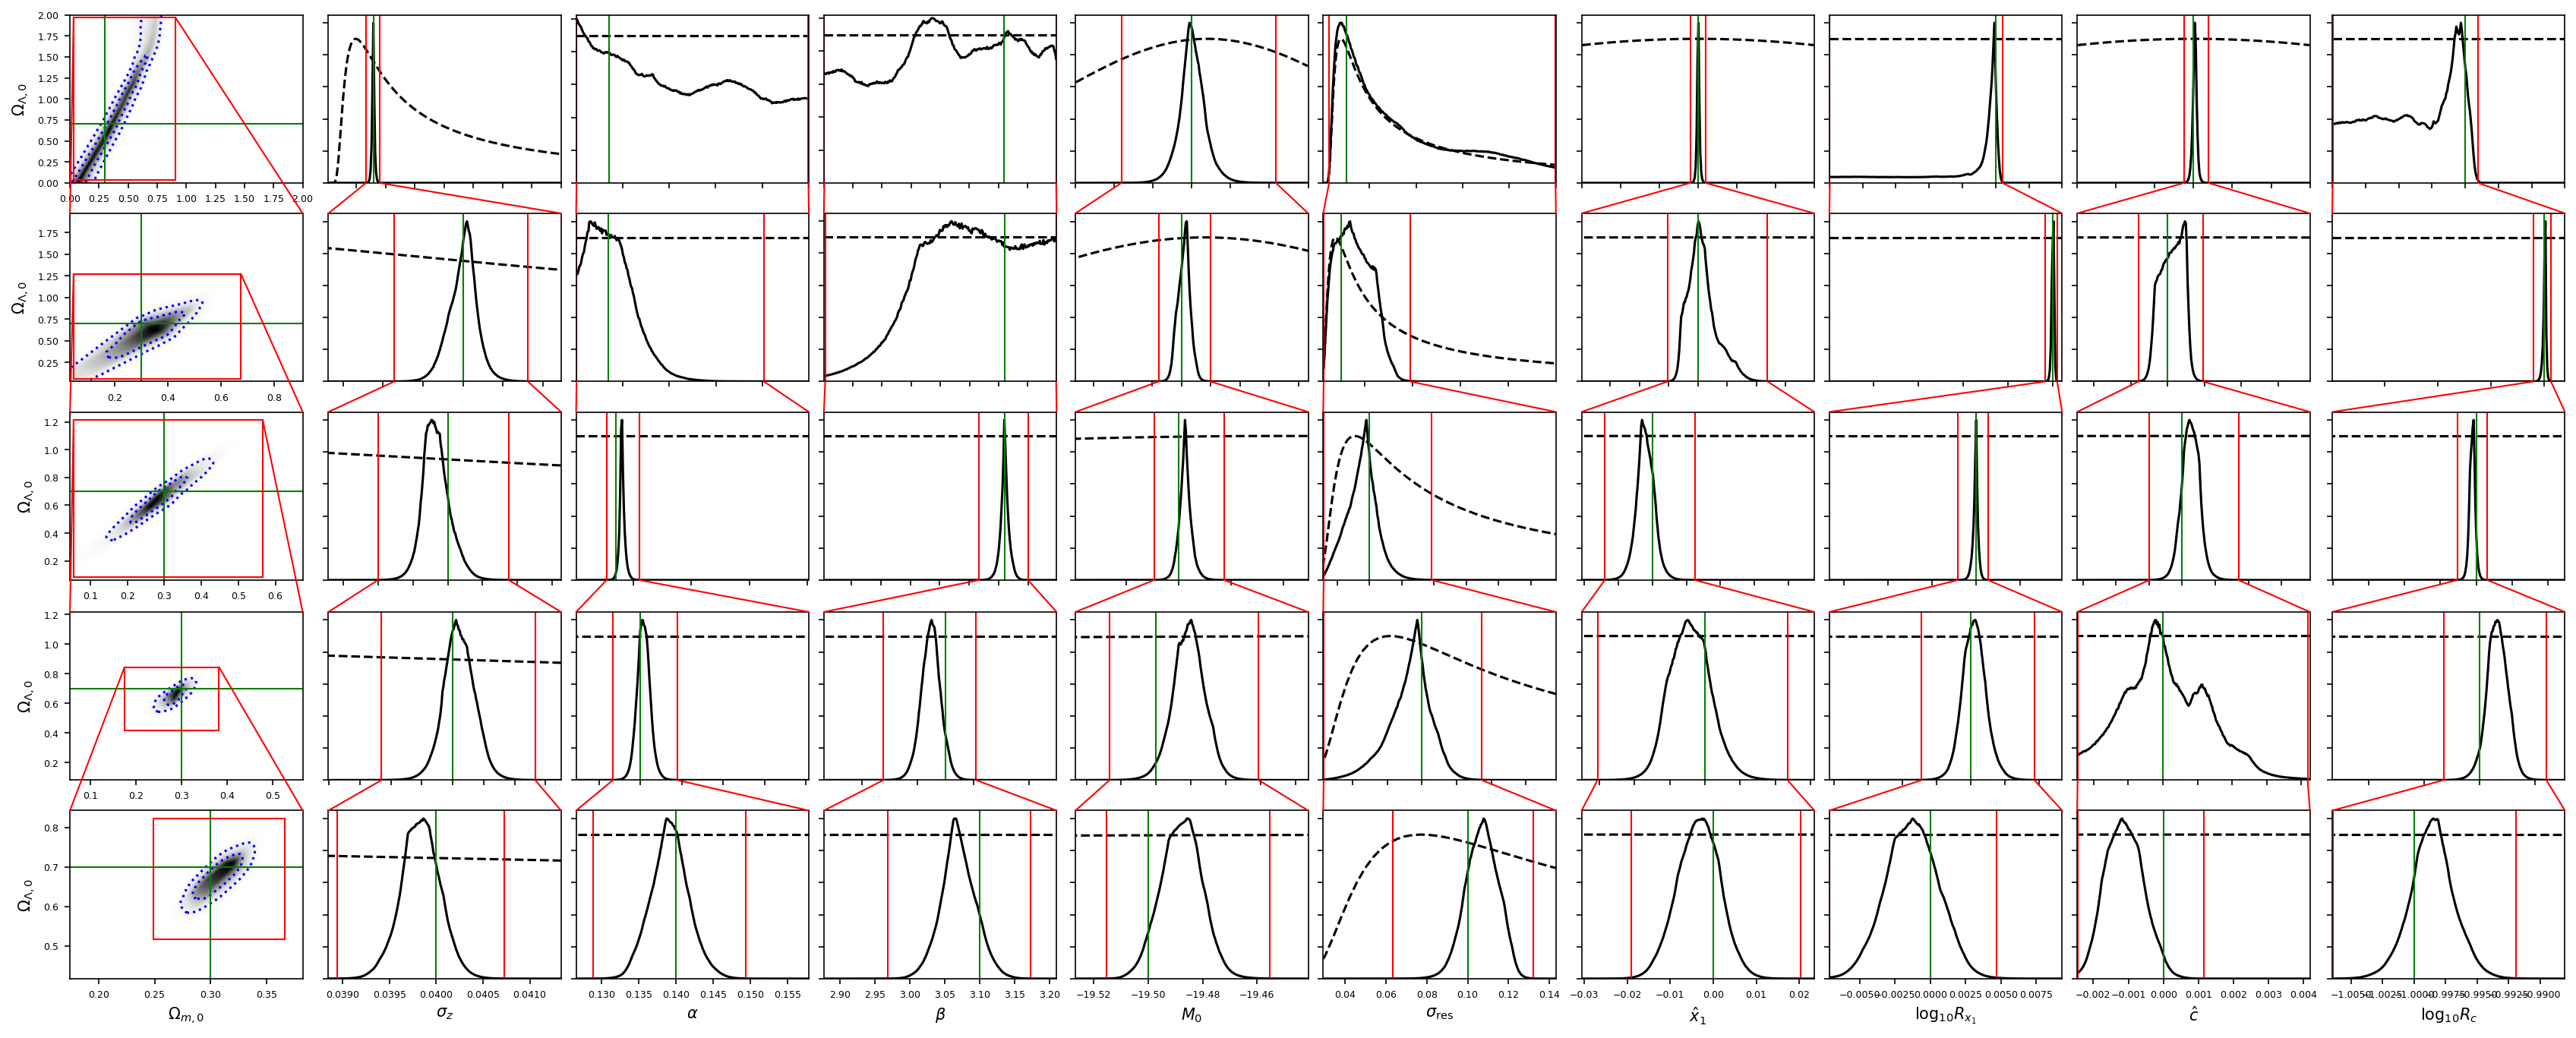

In [7]:
from matplotlib.patches import ConnectionPatch
from itertools import repeat
from typing import Optional
from typing_extensions import TypeAlias
from more_itertools import always_iterable
import seaborn as sns
sns.reset_orig()


# groups = [('Om0', 'Ode0')] + [i for i in zooms.columns.levels[-1] if i not in ('Om0', 'Ode0')]
groups = [
    ('Om0', 'Ode0'), 'sigma_z', 'alpha', 'beta',
    'mean_M0', 'sigma_res', 'mean_x1', 'log10_R_x1', 'mean_c', 'log10_R_c'
]  # manual ordering
zs = zooms.loc[:, :5]
zs = {
    key: {k: (v['lower'], v['upper']) for k, v in zs[key].items()}
    for key in zs.columns.remove_unused_levels().levels[0]
}
truths = simplesn.data


TRUTH_STYLE = dict(color='green', lw=1)
NEXTLIM_STYLE = dict(color='red', lw=1)

LEVELS = (0.68, 0.95)
IMAGE_STYLE = dict(cmap='gray')
CONTOUR_STYLE = dict(colors=('b', 'b', 'k'), linestyles=(':', ':', '-'))

LABELS = defs['labels']


_BoundT: TypeAlias = tuple[float, float]

contours = defaultdict(dict)

def bounds_2d(ax, bound_x: Optional[_BoundT], bound_y: Optional[_BoundT], **kwargs):
    if None not in (bound_x, bound_y):
        ax.add_artist(plt.Rectangle(
            xy=(bound_x[0], bound_y[0]),
            width=bound_x[1] - bound_x[0],
            height=bound_y[1] - bound_y[0],
            fill=False, **kwargs
        ))
    elif not bound_x is None:
        ax.axvline(bound_x[0], **kwargs)
        ax.axvline(bound_x[1], **kwargs)
    elif not bound_y is None:
        ax.axhline(bound_y[0], **kwargs)
        ax.axhline(bound_y[1], **kwargs)


fig, axs = plt.subplots(len(zs)-1, len(groups), figsize=(2.25 * len(groups), 1.5 * len(zs)))
for (axrow, nextaxrow), ((zoom_level, limss), (_, nextlimss)) in zip(
        stagger(axs, (0, 1), longest=True, fillvalue=repeat(None)),
        stagger(zs.items(), (0, 1), longest=True, fillvalue=(None, defaultdict(lambda: pd.NA)))
):
    grids_, posts_ = map(itemgetter(zoom_level), (grids, posts))

    for ax, nextax, group in zip(axrow, nextaxrow, groups):
        ax: plt.Axes

        key = tuple(always_iterable(group))
        lims = {k: limss[k] for k in key}
        nextlims = {k: nextlimss[k] for k in key}
        # nextlims_ = get_bound_from_post(NREPlotter.mesh_grids(grids_, key), posts_[group])

        match len(key):
            case 1:
                key = key[0]

                y = priors[group].rename(None)
                ax.plot(prior_grids[key], 0.9 * y/y.max(), 'k--')

                y = posts_[group].rename(None)
                ax.plot(grids_[key], y/y.max(), 'k-')
        #         ax.set_ylim(top=1)
        #         ax.set_yscale('log')

                ax.axvline(truths[key], **TRUTH_STYLE)

                # ax.axvline(nextlims_[key][0], **{**NEXTLIM_STYLE, 'color': 'black'})
                # ax.axvline(nextlims_[key][1], **{**NEXTLIM_STYLE, 'color': 'black'})

                lims, nextlims = map(itemgetter(key), (lims, nextlims))

                if not pd.isna(lims):
                    ax.set_xlim(*lims)
                if not pd.isna(nextlims):
                    ax.axvline(nextlims[0], **NEXTLIM_STYLE)
                    ax.axvline(nextlims[1], **NEXTLIM_STYLE)

                    if nextax is not None:
                        fig.add_artist(ConnectionPatch((nextlims[0], 0), (0, 1), ax.transData, nextax.transAxes, **NEXTLIM_STYLE))
                        fig.add_artist(ConnectionPatch((nextlims[1], 0), (1, 1), ax.transData, nextax.transAxes, **NEXTLIM_STYLE))

                ax.set_ylim(bottom=0)
                ax.xaxis.set_tick_params(labelbottom=False)
                ax.yaxis.set_tick_params(labelleft=False)
            case 2:
                xlims, ylims = limss[group[0]], limss[group[1]]
                imkwargs = dict(extent=(*xlims, *ylims), origin='lower')

                img = to_percentiles(posts_[group]).align_to(*group[::-1]).rename(None)

                ax.imshow(img, **imkwargs, **IMAGE_STYLE)
                contours[zoom_level][group] = ax.contour(img, **imkwargs, levels=LEVELS, **CONTOUR_STYLE)

                ax.axvline(truths[group[0]], **TRUTH_STYLE)
                ax.axhline(truths[group[1]], **TRUTH_STYLE)

                # bounds_2d(
                #     ax,
                #     None if pd.isna(nextlims_[group[0]]) else nextlims_[group[0]],
                #     None if pd.isna(nextlims_[group[1]]) else nextlims_[group[1]],
                #     **{**NEXTLIM_STYLE, 'color': 'black'}
                # )

                bounds_2d(
                    ax,
                    None if pd.isna(nextlims[group[0]]) else nextlims[group[0]],
                    None if pd.isna(nextlims[group[1]]) else nextlims[group[1]],
                    **NEXTLIM_STYLE, zorder=2
                )

                if not pd.isna(nextlims[group[0]]) and not pd.isna(nextlims[group[1]]) and not nextax is None:
                    fig.add_artist(ConnectionPatch((nextlims[group[0]][0], nextlims[group[1]][1]), (0, 1), ax.transData, nextax.transAxes, **NEXTLIM_STYLE))
                    fig.add_artist(ConnectionPatch((nextlims[group[0]][1], nextlims[group[1]][1]), (1, 1), ax.transData, nextax.transAxes, **NEXTLIM_STYLE))

                ax.set_aspect('auto')

                ax.set_ylabel(LABELS.get(group[1], group[1]))

for ax in axs.flat:
    ax.tick_params(labelsize=6)

for ax, group in zip(axs[-1], groups):
    name = next(always_iterable(group))
    ax.set_xlabel(LABELS.get(name, name))
    ax.xaxis.set_tick_params(labelbottom=True)

### Tikz

In [8]:
from libplotting import to_multidict
from uplot.tikz.pgfdata import to_pgfdata
from uplot.tikz.utils import points_to_coords


paramnames = [i for i in set(zooms.columns.get_level_values('param')) if i not in ('Om0', 'Ode0')]
groups2d = [('Om0', 'Ode0')]

In [11]:
open('paper/plotdata/zooms.tex', 'w').write('\n'.join(map(str, (
    to_pgfdata(to_multidict(zooms.T), f'private/zooms/{simplesn.N}/{simplesn.datatype}/{simplesn.suffix}/{simplesn.version}'),
    to_pgfdata({
        level: {
            param: {'post': points_to_coords(torch.stack((_x, _y / _y.max()), -1), num_fmt='.6e')}
            for param in paramnames for _x, _y in [(grids_[param], posts_[param].rename(None))]
        } | {
            '-'.join(group): {
                'post': r' \par '.join(
                    ' '.join('({:.6e}, {:.6e}) [{:.6e}]'.format(*a) for a in row)
                    for row in torch.stack(
                        torch.meshgrid(*itemgetter(*group)(grids_), indexing='xy')
                        + (posts_[group].align_to(*reversed(group)).rename(None),),
                        dim=-1
                    )
                ),
                'contours': [points_to_coords(c) for c in ctrs[group].allsegs]
            } for group in groups2d
        }
        for level in grids.keys() for grids_, posts_, ctrs in [(grids[level], posts[level], contours[level])]
    }, f'private/zooms/{simplesn.N}/{simplesn.datatype}/{simplesn.suffix}/{simplesn.version}'),
    to_pgfdata({
        param: points_to_coords(torch.stack((_x, _y / _y.max()), -1), num_fmt='.6e')
        for param in paramnames for _x, _y in [(prior_grids[param], priors[param].rename(None))]
    }, 'private/priors')
))))

4061509